In [828]:
import os
import wget 
import clipboard
import matplotlib.pyplot as plt
import cv2
import geopy
import time
from datetime import timedelta
from datetime import datetime
from geopy.geocoders import Nominatim
import pandas as pd
geolocator = Nominatim(user_agent="tryGCV")

from google.cloud import vision
from google.cloud.vision_v1 import types

KEY_PATH = '/Users/jiji/gcloudstuff/apikey.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = KEY_PATH



In [947]:
def show_image(url):
    wget.download(url, out='test.jpg')
    img = cv2.cvtColor(cv2.imread('test.jpg'), cv2.COLOR_BGR2RGB)
#     img=cv2.resize(img,(256,128))
    plt.imshow(img)
    plt.axis('off');
    !rm test.jpg

In [871]:
def detect_landmark(image):
#     image = types.Image()
#     image.source.image_uri = img_uri

    landmark_response = client.landmark_detection(image)
    landmarks = landmark_response.landmark_annotations
    
    if len(landmarks)==0:
        return None
    else:
        landmark = landmarks[0]

        landmark_name = landmark.description

        lat_lng = landmark.locations[0].lat_lng        
        lat = lat_lng.latitude
        lng = lat_lng.longitude
        
#         return lat, lng

        city, country, code, landmark_alias = get_location_from(lat, lng)

        names = {landmark_name, landmark_alias}


        return {'names':names, 'city':city, 'country':country, 'country_code':code}


In [872]:
def get_location_from(latitude, longitude):
    lat_long = ', '.join((str(latitude), str(longitude)))
    location = geolocator.reverse(lat_long, language='en')
#     return location
    address = location.raw['address']
    
    city = address.get('state') or adress.get('city')
    country = address.get('country')
    code = address['country_code']
    landmark_name = address.get('tourism') or address.get('road')
    
    return city, country, code, landmark_name

In [873]:
def get_labels(image):
    
    label_response = client.label_detection(image)
    labels = set()
    for label in label_response.label_annotations:
        labels.add(label.description)
    return labels
    
    

### Testing GCV API

In [874]:
client = vision.ImageAnnotatorClient()
image = types.Image()

##### Example 1

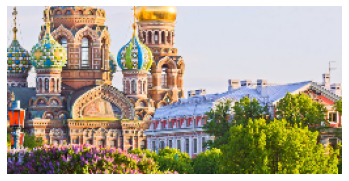

In [888]:
img_uri='https://moya-planeta.ru/upload/images/xl/ed/6d/ed6da55b69fd03579db9a7654b31fffd.jpg'
image.source.image_uri = img_uri
show_image(img_uri)

In [889]:
detect_landmark(image)

{'names': {'Church of the Savior on Blood',
  'The Church of Our Savior on the Spilled Blood'},
 'city': 'Saint Petersburg',
 'country': 'Russia',
 'country_code': 'ru'}

In [577]:
get_labels(image)

{'City',
 'Daytime',
 'Facade',
 'Nature',
 'Plant',
 'Sky',
 'Temple',
 'Tree',
 'Window',
 'Yellow'}

##### Example 2

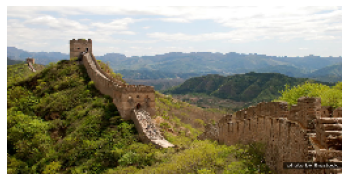

In [894]:
img_uri='https://images.chinahighlights.ru/allpicture/2014/10/a42c2b68331d46fb9a80aa66_cp_799x534.jpg'
image.source.image_uri = img_uri
show_image(img_uri)

In [895]:
detect_landmark(image)

{'names': {'Great Wall of China'},
 'city': 'Beijing',
 'country': 'China',
 'country_code': 'cn'}

In [896]:
get_labels(image)

{'Cloud',
 'Landscape',
 'Mountain',
 'Natural landscape',
 'Plant',
 'Plant community',
 'Sky',
 'Terrain',
 'Travel',
 'Wonders of the world'}

### Selenium InstaScrapper

In [1]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys


from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By

from selenium.webdriver.support.wait import WebDriverWait
from bs4 import BeautifulSoup

In [784]:
class InstaScrapper():
    
    def __init__(self, username, password):
        self.username = username
        self.password = password
        self.accounts = []

        self.driver = webdriver.Chrome("./chromedriver")
        
        self.ec = EC
        self.by = By
        self.webDriverWait = WebDriverWait

        self.login()
        self._timedelta = timedelta(365*5)
        
        self.db = []
        
        self.max_posts = 10

    def login(self):
        self.driver.get("https://www.instagram.com/")
        
        username_cell = self.webDriverWait(self.driver, 10).until(
            self.ec.element_to_be_clickable((self.by.CSS_SELECTOR, "input[name='username']")))
        password_cell = self.webDriverWait(self.driver, 10).until(
            self.ec.element_to_be_clickable((self.by.CSS_SELECTOR, "input[name='password']")))

        username_cell.clear(); password_cell.clear();
        username_cell.send_keys(self.username)
        password_cell.send_keys(self.password)

        log_in = self.webDriverWait(self.driver, 10).until(
            self.ec.element_to_be_clickable((self.by.CSS_SELECTOR, "button[type='submit']"))).click()
        
        time.sleep(3)
        

    def explore_hashtag(self, hashtag):
        self.driver.get("https://www.instagram.com/explore/tags/"+hashtag.replace('#','')+'/')
        
        
    def explore_user(self, user_name):
        self.driver.get("https://www.instagram.com"+'/'+user_name.replace('/','')+'/')


    def collect_users_from_hashtag(self, hashtag, n_users):
    
        self.explore_hashtag(hashtag)
        
        self.webDriverWait(self.driver, 15).until(
            self.ec.element_to_be_clickable((self.by.CLASS_NAME, '_9AhH0'))).click()
        
        for _ in range(n_users):
            
            self.webDriverWait(self.driver, 10).until(
                self.ec.presence_of_element_located((
                self.by.XPATH, "//a[@class='sqdOP yWX7d     _8A5w5   ZIAjV ']")))
            
            user_name = self.driver.find_element_by_xpath("//a[@class='sqdOP yWX7d     _8A5w5   ZIAjV ']").text
            self.accounts.append(user_name)
            
            self.webDriverWait(self.driver, 14).until(
                self.ec.element_to_be_clickable((
                self.by.CLASS_NAME, 'coreSpriteRightPaginationArrow'))).click()
            
        return self.accounts      
    
    
    def build_database(self):
        for user_name in self.accounts:
            self.collect_user_data(user_name)  
            
            
    def collect_user_data(self, user_name):
        self.explore_user(user_name)
        
        self.webDriverWait(self.driver, 15).until(
            self.ec.element_to_be_clickable((self.by.CLASS_NAME, '_9AhH0'))).click()
        
        user_img_src = []; user_desc = []; user_loc = []
        
        posts_counter=0
        while True:
            
            if self.max_posts < posts_counter:
                break
            posts_counter+=1
                
            post_date = self.get_post_date()
            
            if datetime.now() - post_date > self._timedelta:
                break
                
            post_img_src = self.get_post_img_src()
            
            if post_img_src: 
                post_desc = self.get_post_description(user_name)
                post_loc = self.get_post_location()
                
                user_img_src.append(post_img_src)
                user_desc.append(post_desc)
                user_loc.append(post_loc)
                
            try:
                self.webDriverWait(self.driver, 14).until(
                    self.ec.element_to_be_clickable((
                    self.by.CLASS_NAME, 'coreSpriteRightPaginationArrow'))).click()
            except:
                break
                
        self.db.append([[user_name], user_img_src, user_desc, user_loc])
        
            
    def get_post_img_src(self):
        try: 
            self.webDriverWait(self.driver, 10).until(
                self.ec.presence_of_element_located((
                self.by.XPATH, "//div[@class='KL4Bh'][@style]/img")))

            return scrapper.driver.find_element_by_xpath(
                    "//div[@class='KL4Bh'][@style]/img").get_attribute('src')
        except:
            return None


    def get_post_description(self, user_name):
        try:
            annotation = self.driver.find_element_by_xpath("//div[@class='C4VMK']/span").text
            commentator = self.driver.find_elements_by_xpath("//a[@class='sqdOP yWX7d     _8A5w5   ZIAjV ']")[1].text
            if user_name.replace('/','') == commentator:
                return annotation
            else:
                return 'No description'
        except:
            return 'No description'
    

    def get_post_date(self):
        self.webDriverWait(self.driver,10).until(
            self.ec.presence_of_element_located((
            self.by.XPATH, "//time[@class='_1o9PC Nzb55']")))
        
        date_str = self.driver.find_element_by_xpath("//time[@class='_1o9PC Nzb55']").get_attribute('datetime')[:10]

        return datetime.fromisoformat(date_str)
    

    def get_post_location(self):
        try:
            return self.driver.find_element_by_xpath("//a[@class='O4GlU']").text
        except:
            return 'Unknown location'


In [934]:
login_data = dict()
with open('login_data.txt', 'r') as f:
    for line in f:
        key, val = line.split(': ')
        login_data[key] = val.split('\n')[0]

In [785]:
scrapper = InstaScrapper(login_data['login'],login_data['password'])

In [786]:
scrapper.collect_users_from_hashtag('travel', n_users=2)
scrapper.collect_users_from_hashtag('travelphotography',n_users=2)

['madeinthenetherlands', 'therighttoexplore', 'maliane', 'antoniijja']

In [787]:
scrapper.build_database()

In [815]:
df = pd.DataFrame(scrapper.db)
df[0] = df[0].apply(lambda x: x[0])
df = df.rename(columns={0:'user_name', 1:'img_src', 2:'post_descriptions', 3:'locations'})
df = df.set_index('user_name')
df

,img_src,post_descriptions,locations
user_name,,,
madeinthenetherlands,[https://scontent-arn2-1.cdninstagram.com/v/t5...,[#like #likeforlikes #like4likes #likeforlike ...,"[Groningen, Netherlands, Amsterdam, Netherland..."
therighttoexplore,[https://scontent-arn2-1.cdninstagram.com/v/t5...,[Insane shot of the iconic firefall in Yosemit...,"[Yosemite National Park, North Cascades Nation..."
maliane,[https://scontent-arn2-1.cdninstagram.com/v/t5...,[#Amsterdam ❌ ❌ ❌\nWhat a beautiful day today ...,"[Prinsengracht, Lauriergracht, Amstel 1, 's-Gr..."
antoniijja,[],[],[]


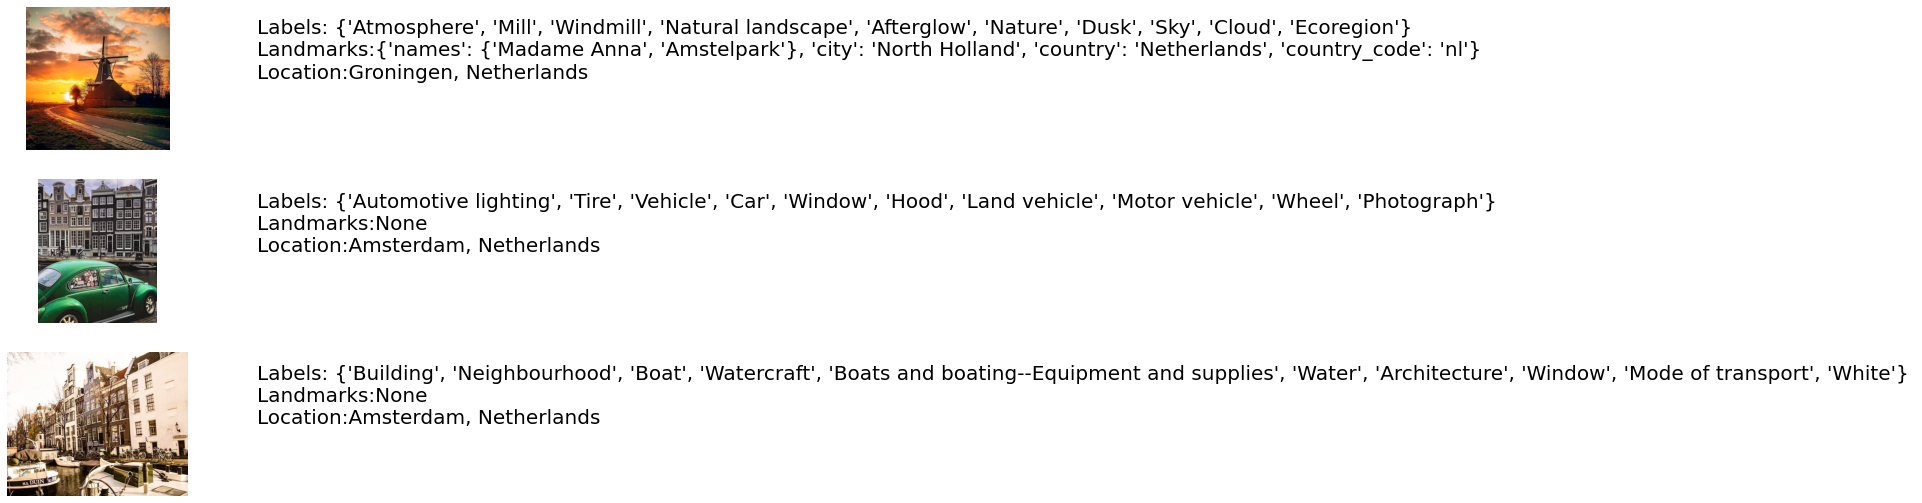

In [958]:
n = 3
plt.figure(figsize=(9,9))
for i, (source, loc) in enumerate(zip(
    df.loc['madeinthenetherlands'].img_src, df.loc['madeinthenetherlands'].locations), 1):
    
    image.source.image_uri = source
    plt.subplot(n,2, i*2-1)
    show_image(source)
    plt.subplot(n,2, i*2)
    plt.axis('off')
    plt.text(0,0.5,
             s=f"Labels: {get_labels(image)} \nLandmarks:{detect_landmark(image)} \nLocation:{loc}",
             fontsize=20);
    if i>=n:
        break